# Reproduction of T-Drive trajectory plots 
The goal is to reproduce the figures of published article by Yu Zheng: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/User_guide_T-drive.pdf at Microsoft Research in Asia, based on the dataset contains GPS trajectories of taxis in Beijing during the period of Feb, 2, 2008 to Feb, 8, 2008. 

Comments: The data they provided in: https://www.microsoft.com/en-us/research/publication/t-drive-trajectory-data-sample/ is not the complete dataset as they used to produce the original plot, then the reproduced plots are slightly diffrent.

# Citations:

[1] Jing Yuan, Yu Zheng, Xing Xie, and Guangzhong Sun. Driving with knowledge from the physical world.
In The 17th ACM SIGKDD international conference on Knowledge Discovery and Data mining, KDD’11, New York, NY, USA, 2011. ACM.
[2] Jing Yuan, Yu Zheng, Chengyang Zhang, Wenlei Xie, Xing Xie, Guangzhong Sun, and Yan Huang. Tdrive:
driving directions based on taxi trajectories. In Proceedings of the 18th SIGSPATIAL International
Conference on Advances in Geographic Information Systems, GIS ’10, pages 99–108, New York, NY, USA, 2010. ACM.

Importing necessary libraries:

In [38]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

Reading data

In [3]:
Data = pd.DataFrame()
F= []
for root, dirs, files in os.walk('data3'):
    for name in files:
        F.append(os.path.join(root, name))
D=[]
for index, file_path in enumerate(F):
    D.append(pd.read_csv(file_path,header=None,parse_dates = [1],\
                        names= ['taxi_id', 'date_time', 'longitude', 'latitude']))

Data=Data.append(D,ignore_index=True)
Data.drop_duplicates(inplace=True)
Data.dropna(inplace=True)

In [4]:
Data.shape

(9259014, 4)

Extract the time intervals between two consecutive points of a taxi. It is claimed in the article that the average time intervals between two consecutive points is about 177 seconds, which I found it as 293 sec (for tripss shorter than 1000 Sec) and this diffrenec comes for the fact that the dataset used for the article has 15 millions raws and the dataset I worked with has about 9 milliions.  

In [39]:
D_diff=Data.sort_values(by='date_time',ascending=1).groupby('taxi_id').diff()
D_diff.dropna(inplace=True)
T=D_diff.iloc[:,0]
T /= np.timedelta64(1,'s')
T=D_diff.iloc[:,0]
print('Average time interval: ', T[T < 1e3].mean(), 'Sec')
T /= 60

Average time interval:  293.0256418924161 Sec


Sorting and grouping the data to find the GPS coordinates between consecutive points.

In [42]:
lon = pd.DataFrame()
lat = pd.DataFrame()
D_group=Data.sort_values(by='date_time',ascending=1).groupby('taxi_id')
Lon=[]
Lat=[]
for g in D_group:
    Lon.append(g[1]['longitude'])
    Lat.append(g[1]['latitude'])

lon=pd.concat(Lon,ignore_index=True)
lat=pd.concat(Lat,ignore_index=True)
lon.dropna(inplace=True)
lat.dropna(inplace=True)

Calculating the distance between points based on GPS coordinates and reporting the average distance interval for trips shorter than 100 Km.

In [43]:
lat=np.array(lat)*3.14/180
lon=np.array(lon)*3.14/180
lon1=lon[0:-1]
lon2=lon[1:]
lat1=lat[0:-1]
lat2=lat[1:]
Delta_lat=lat2-lat1
Delta_lon=lon2-lon1
a=(np.sin(Delta_lat/2))**2 +((np.sin(Delta_lon/2))**2) * np.cos(lat1) * np.cos(lat2)
Distance=6371*1000*2 * np.arctan((np.sqrt(a))/(np.sqrt(1-a))) 
print('Average distance inteval: ', Distance[Distance<1e5].mean(), 'meters')

Average distance inteval:  1022.18080678 meters


Plotting histograms of time and distance intervals

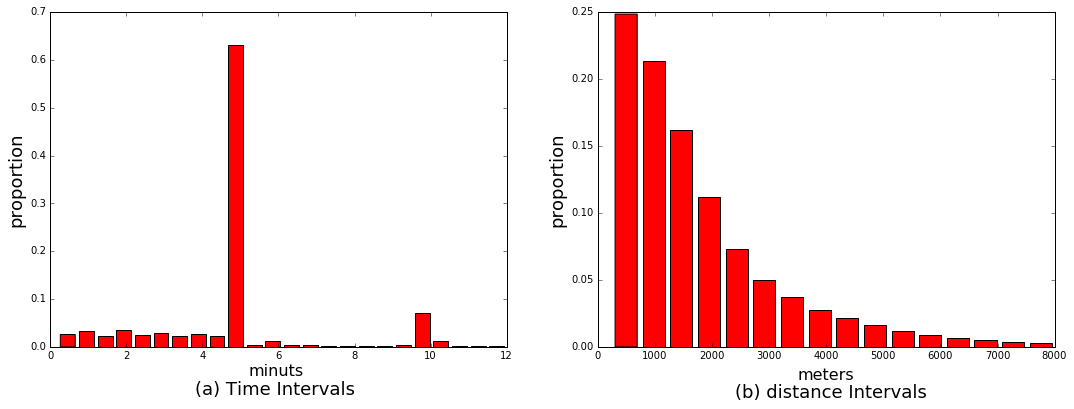

In [46]:
T_Interval=T
fig = plt.figure(figsize=(18,6), dpi=1600) 
ax1 = plt.subplot2grid((1,2),(0,0))
plt.hist(T_Interval[(T_Interval > 0.2) & (T_Interval < 12) ],bins=24,rwidth=0.8,color='r',\
         weights=np.zeros_like(T_Interval[(T_Interval >0.2) & (T_Interval < 12) ])\
         + 1. / T_Interval[(T_Interval > 0.2) & (T_Interval < 12) ].size)
#plt.title('(a) Time Intervals')
#plt.xlabel('minuts\n(a) Time Intervals',fontsize=18)
plt.ylabel('proportion',fontsize=18)
plt.text(5.2,-0.06,'minuts',fontsize=16)
plt.text(3.8,-0.1,'(a) Time Intervals',fontsize=18)
ax2 = plt.subplot2grid((1,2),(0,1))
plt.hist(Distance[(Distance < 8000)&(Distance > 250)],bins=16,rwidth=0.8,color='r',\
         weights=np.zeros_like(Distance[(Distance < 8000)&(Distance > 250)])\
         + 1. / Distance[(Distance < 8000)&(Distance > 250)].size)
plt.text(3500,-0.025,'meters',fontsize=16)
plt.text(2400,-0.038,'(b) distance Intervals',fontsize=18)
plt.ylabel('proportion',fontsize=18)

plt.show()

Plotting the distribution of GPS points, where the color indicates the density of the points.

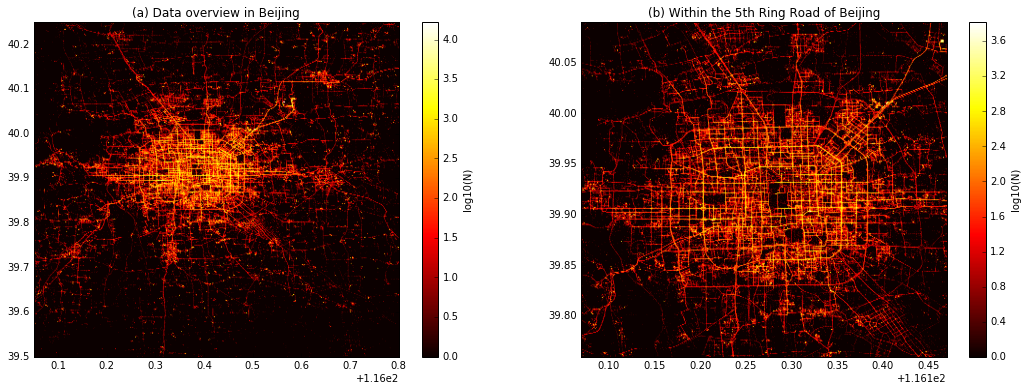

In [62]:
Beijing = Data[(116.05 < Data.longitude) & (Data.longitude < 116.8) & (39.5 < Data.latitude) & ( Data.latitude < 40.25)]

plt.figure(figsize = (18,6), dpi=150)
ax1 = plt.subplot2grid((1,2),(0,0))
plt.hexbin(Beijing.longitude,Beijing.latitude,bins='log', gridsize=600, cmap=plt.cm.hot)   
plt.axis([116.05, 116.8, 39.5, 40.25])
plt.title("(a) Data overview in Beijing")
cb = plt.colorbar()
cb.set_label('log10(N)')

ax2 = plt.subplot2grid((1,2),(0,1))
Ring_Road = Data[(116.17 < Data.longitude) & (Data.longitude < 116.57) & (39.76 < Data.latitude) & ( Data.latitude < 40.09)]
plt.hexbin(Ring_Road.longitude,Ring_Road.latitude,bins='log', gridsize=600, cmap=plt.cm.hot)   
plt.axis([116.17, 116.57, 39.76, 40.09])
plt.title("(b) Within the 5th Ring Road of Beijing")
cb = plt.colorbar()
cb.set_label('log10(N)')

plt.show()